# **Synthetic Shrimp Image Generation with GAN**

# This notebook generates synthetic shrimp images based on a dataset of real shrimp images


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import os
import time
from PIL import Image
from glob import glob
import pathlib

In [2]:
# For reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [11]:
# 1. Extract the uploaded shrimps.zip file
# First, check if the file exists and where it's located
!ls -la

# If the file is in the wrong location or has a different name, find it
!find / -name "*.zip" -type f 2>/dev/null | grep -i shrimp

# Check the content of the sample_data directory (Colab sometimes puts files here)
!ls -la sample_data

# Method 1: Try to unzip the file with the correct path
# Replace "shrimps.zip" with the actual path found above if different
!unzip -q shrimps.zip -d /content/shrimp_images
!ls -la /content/shrimp_images  # Check if extraction worked

# Method 2: If unzip doesn't work, use a direct file upload approach
from google.colab import files
import os
import shutil

# Create directory for shrimp images
!mkdir -p /content/shrimp_images

# Option to upload images directly
def upload_and_extract():
    print("Please upload your shrimp images directly (you can select multiple files)")
    uploaded = files.upload()

    for filename in uploaded.keys():
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            shutil.copy(filename, f'/content/shrimp_images/{filename}')

    print(f"Saved {len(uploaded)} images to /content/shrimp_images")
    return len(uploaded) > 0

# Run this if needed - uncomment the line below if the unzip method doesn't work
# upload_successful = upload_and_extract()

# Set the correct dataset path
DATASET_PATH = "/content/shrimp_images"
print(f"Dataset path set to: {DATASET_PATH}")

# Verify images were found
import glob
image_files = glob.glob(f"{DATASET_PATH}/*.jpg") + glob.glob(f"{DATASET_PATH}/*.jpeg") + glob.glob(f"{DATASET_PATH}/*.png")
print(f"Found {len(image_files)} images in {DATASET_PATH}")

# If no images found, prompt for direct upload
if len(image_files) == 0:
    print("No images found. Let's try direct upload instead.")
    upload_and_extract()
    # Check again
    image_files = glob.glob(f"{DATASET_PATH}/*.jpg") + glob.glob(f"{DATASET_PATH}/*.jpeg") + glob.glob(f"{DATASET_PATH}/*.png")
    print(f"Now found {len(image_files)} images in {DATASET_PATH}")


total 80884
drwxr-xr-x 1 root root     4096 Mar  7 04:16 .
drwxr-xr-x 1 root root     4096 Mar  7 04:06 ..
drwxr-xr-x 4 root root     4096 Mar  5 14:26 .config
-rw-r--r-- 1 root root 76510602 Mar  7 04:17 drive-download-20250307T034005Z-001.zip
drwxr-xr-x 2 root root     4096 Mar  7 04:16 .ipynb_checkpoints
drwxr-xr-x 1 root root     4096 Mar  5 14:26 sample_data
-rw-r--r-- 1 root root  6291456 Mar  7 04:16 shimps.zip
total 55512
drwxr-xr-x 1 root root     4096 Mar  5 14:26 .
drwxr-xr-x 1 root root     4096 Mar  7 04:16 ..
-rwxr-xr-x 1 root root     1697 Jan  1  2000 anscombe.json
-rw-r--r-- 1 root root   301141 Mar  5 14:26 california_housing_test.csv
-rw-r--r-- 1 root root  1706430 Mar  5 14:26 california_housing_train.csv
-rw-r--r-- 1 root root 18289443 Mar  5 14:26 mnist_test.csv
-rw-r--r-- 1 root root 36523880 Mar  5 14:26 mnist_train_small.csv
-rwxr-xr-x 1 root root      962 Jan  1  2000 README.md
unzip:  cannot find or open shrimps.zip, shrimps.zip.zip or shrimps.zip.ZIP.
ls: ca

Saving IMG_0027.JPG to IMG_0027.JPG
Saving IMG_0028.JPG to IMG_0028.JPG
Saving IMG_0029.JPG to IMG_0029.JPG
Saving IMG_0030.JPG to IMG_0030.JPG
Saving IMG_0031.JPG to IMG_0031.JPG
Saving IMG_0033.JPG to IMG_0033.JPG
Saving prawn_0_789.jpeg to prawn_0_789.jpeg
Saving prawn_0_2183.jpeg to prawn_0_2183.jpeg
Saving prawn_0_2905.jpeg to prawn_0_2905.jpeg
Saving two hundred  five.jpg to two hundred  five.jpg
Saving two hundred  three.jpg to two hundred  three.jpg
Saving two hundred eighty two.jpg to two hundred eighty two.jpg
Saving two hundred fifty one.jpg to two hundred fifty one.jpg
Saving two hundred seventy eight.jpg to two hundred seventy eight.jpg
Saving two hundred twenty six.jpg to two hundred twenty six.jpg
Saving two hundred twenty three.jpg to two hundred twenty three.jpg
Saving two hundred twenty two.jpg to two hundred twenty two.jpg
Saving two hundred twenty.jpg to two hundred twenty.jpg
Saved 18 images to /content/shrimp_images
Now found 12 images in /content/shrimp_images


In [12]:
import glob
image_files = glob.glob("/content/shrimp_images/*.jpg") + glob.glob("/content/shrimp_images/*.jpeg") + glob.glob("/content/shrimp_images/*.png")
print(f"Found {len(image_files)} images in the dataset directory")

# Configuration Parameters
IMAGE_SIZE = 128  # Resize images to this size
BATCH_SIZE = 16   # Smaller batch size for small dataset
BUFFER_SIZE = 1000
EPOCHS = 300      # Increased for small dataset
LEARNING_RATE = 2e-5  # Reduced learning rate for stability
noise_dim = 100
num_examples_to_generate = 16
SAVE_INTERVAL = 10  # Save model every N epochs

Found 12 images in the dataset directory


In [13]:
# Function to load and preprocess the images with augmentation
def load_and_preprocess_data(data_path):
    # Create a dataset from the directory
    data_dir = pathlib.Path(data_path)

    # Get list of image files
    image_files = list(data_dir.glob('**/*.jpg')) + list(data_dir.glob('**/*.jpeg')) + list(data_dir.glob('**/*.png'))

    if len(image_files) == 0:
        raise ValueError(f"No image files found in {data_path}")

    print(f"Found {len(image_files)} images")

    def load_image(file_path):
        # Read the image file
        img = tf.io.read_file(file_path)
        # Decode the image
        img = tf.image.decode_image(img, channels=3, expand_animations=False)
        # Resize the image
        img = tf.image.resize(img, [IMAGE_SIZE, IMAGE_SIZE])
        return img

    def augment_image(img):
        # Apply random augmentations
        # Random flip left-right
        img = tf.image.random_flip_left_right(img)
        # Random flip up-down
        img = tf.image.random_flip_up_down(img)
        # Random brightness
        img = tf.image.random_brightness(img, max_delta=0.2)
        # Random contrast
        img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
        # Random rotation (in multiples of 90 degrees)
        k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
        img = tf.image.rot90(img, k=k)
        # Random saturation
        img = tf.image.random_saturation(img, lower=0.8, upper=1.2)
        # Random hue
        img = tf.image.random_hue(img, max_delta=0.1)
        # Ensure values are in valid range after augmentations
        img = tf.clip_by_value(img, 0, 255)
        # Normalize to [-1, 1]
        img = (tf.cast(img, tf.float32) - 127.5) / 127.5
        return img

    # Create a dataset of file paths
    path_ds = tf.data.Dataset.from_tensor_slices([str(path) for path in image_files])

    # Load images
    image_ds = path_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

    # Create a larger dataset with augmentations (multiply small dataset)
    AUGMENTATION_FACTOR = 15  # Create 15x more images through augmentation
    augmented_ds = image_ds.repeat(AUGMENTATION_FACTOR).map(
        augment_image, num_parallel_calls=tf.data.AUTOTUNE)

    # Cache, shuffle, batch, and prefetch the dataset
    # Using a smaller batch size for the small dataset
    effective_batch_size = min(BATCH_SIZE, 16)  # Smaller batch size for small dataset
    dataset = augmented_ds.cache().shuffle(BUFFER_SIZE).batch(effective_batch_size).prefetch(tf.data.AUTOTUNE)

    print(f"Created augmented dataset with approximately {len(image_files) * AUGMENTATION_FACTOR} images")

    return dataset


In [14]:
# Build the generator model
def make_generator_model():
    model = models.Sequential()

    # Foundation for 8x8x1024
    model.add(layers.Dense(8*8*1024, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Reshape to 8x8x1024
    model.add(layers.Reshape((8, 8, 1024)))

    # Upsample to 16x16x512
    model.add(layers.Conv2DTranspose(512, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Upsample to 32x32x256
    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Upsample to 64x64x128
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Upsample to 128x128x64
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Output layer with 3 channels (RGB)
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))

    return model

# Build the discriminator model
def make_discriminator_model():
    model = models.Sequential()

    # First convolutional layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[IMAGE_SIZE, IMAGE_SIZE, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second convolutional layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third convolutional layer
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Fourth convolutional layer
    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Flatten and output
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [15]:
# Define loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Setup optimizers with slower learning rate
generator_optimizer = optimizers.Adam(LEARNING_RATE, beta_1=0.5)
discriminator_optimizer = optimizers.Adam(LEARNING_RATE, beta_1=0.5)

# Create the models
generator = make_generator_model()
discriminator = make_discriminator_model()

# Generate seed for visualization
seed = tf.random.normal([num_examples_to_generate, noise_dim])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
# Training step
@tf.function
def train_step(images):
    noise = tf.random.normal([images.shape[0], noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

# Function to generate and save images
def generate_and_save_images(model, epoch, test_input, output_dir='shrimp_gan_images'):
    # Ensure output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Generate images
    predictions = model(test_input, training=False)

    plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        # Convert from [-1, 1] to [0, 1]
        img = (predictions[i, :, :, :] + 1) / 2.0
        plt.imshow(img)
        plt.axis('off')

    plt.savefig(f'{output_dir}/image_at_epoch_{epoch:04d}.png')
    plt.close()

    # Save individual images in the last epoch or at specified intervals
    if epoch % 10 == 0 or epoch == EPOCHS:
        individual_dir = f'{output_dir}/individual_epoch_{epoch}'
        if not os.path.exists(individual_dir):
            os.makedirs(individual_dir)

        for i in range(predictions.shape[0]):
            img = (predictions[i, :, :, :] + 1) / 2.0
            # Convert to uint8 [0, 255]
            img = (img * 255).numpy().astype(np.uint8)
            # Create PIL image and save
            Image.fromarray(img).save(f'{individual_dir}/sample_{i+1}.png')


In [17]:
# Training function with early stopping and model saving
def train(dataset, epochs, output_dir='shrimp_gan_images'):
    # Create directory for saving images and models
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    model_dir = f'{output_dir}/saved_models'
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    # Initialize loss history
    gen_loss_history = []
    disc_loss_history = []

    # For early stopping if needed
    best_loss = float('inf')
    patience_counter = 0
    PATIENCE = 30  # Number of epochs to wait for improvement

    # Training loop
    for epoch in range(epochs):
        start = time.time()

        epoch_gen_loss = 0
        epoch_disc_loss = 0
        steps = 0

        for image_batch in dataset:
            g_loss, d_loss = train_step(image_batch)
            epoch_gen_loss += g_loss
            epoch_disc_loss += d_loss
            steps += 1

            # Break if no images in batch (unlikely but as a safeguard)
            if steps == 0:
                break

        # Calculate average loss
        if steps > 0:
            epoch_gen_loss /= steps
            epoch_disc_loss /= steps

            # Store loss history
            gen_loss_history.append(epoch_gen_loss)
            disc_loss_history.append(epoch_disc_loss)

        # Generate and save images
        generate_and_save_images(generator, epoch + 1, seed, output_dir)

        # Save model at regular intervals
        if (epoch + 1) % SAVE_INTERVAL == 0:
            generator.save(f'{model_dir}/generator_epoch_{epoch+1}.h5')
            print(f"Model saved at epoch {epoch+1}")

        # Print progress
        print(f'Epoch {epoch + 1}/{epochs}, Gen Loss: {epoch_gen_loss:.4f}, Disc Loss: {epoch_disc_loss:.4f}, Time: {time.time()-start:.2f} sec')

        # Early stopping check based on generator loss
        current_loss = epoch_gen_loss
        if current_loss < best_loss:
            best_loss = current_loss
            patience_counter = 0
            # Save best model
            generator.save(f'{model_dir}/generator_best.h5')
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f"Early stopping triggered at epoch {epoch+1} due to no improvement for {PATIENCE} epochs")
                break

    # Plot loss history
    plt.figure(figsize=(10, 5))
    plt.plot(gen_loss_history, label='Generator Loss')
    plt.plot(disc_loss_history, label='Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f'{output_dir}/loss_history.png')
    plt.close()

    # Save the final model
    generator.save(f'{model_dir}/generator_final.h5')
    print("Final model saved")

In [18]:
def generate_synthetic_batch(model, n_samples=100, output_dir='synthetic_shrimps'):
    # Ensure output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Generate random noise
    noise = tf.random.normal([n_samples, noise_dim])

    # Generate images
    generated_images = model(noise, training=False)

    # Save each image
    for i in range(n_samples):
        # Convert from [-1, 1] to [0, 1]
        img = (generated_images[i, :, :, :] + 1) / 2.0
        # Convert to uint8 [0, 255]
        img = (img * 255).numpy().astype(np.uint8)
        # Create PIL image and save
        Image.fromarray(img).save(f'{output_dir}/synthetic_shrimp_{i+1}.png')

    print(f'Generated {n_samples} synthetic shrimp images in {output_dir}')

    # Display a grid of sample images
    plt.figure(figsize=(10, 10))
    for i in range(min(25, n_samples)):
        plt.subplot(5, 5, i+1)
        img = (generated_images[i, :, :, :] + 1) / 2.0
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/sample_grid.png')
    plt.show()


Loading shrimp image dataset...
Found 12 images
Created augmented dataset with approximately 180 images

Generator Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 65536)               │       6,553,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 65536)               │         262,144 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 8, 8, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 16, 16, 512)         │      13,107,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 32, 32, 256)         │       3,276,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 64, 64, 128)         │         819,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 128, 128, 64)        │         204,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 128, 128, 3)         │           4,800 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,232,384 (92.44 MB)

 Trainable params: 24,099,392 (91.93 MB)

 Non-trainable params: 132,992 (519.50 KB)


Discriminator Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 64)          │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 256)         │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 512)           │       3,277,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │          32,769 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,339,329 (16.55 MB)

 Trainable params: 4,339,329 (16.55 MB)

 Non-trainable params: 0 (0.00 B)


Starting GAN training...


Epoch 1/300, Gen Loss: 0.7265, Disc Loss: 1.3165, Time: 36.45 sec
Epoch 2/300, Gen Loss: 0.7342, Disc Loss: 1.1171, Time: 2.86 sec
Epoch 3/300, Gen Loss: 0.8261, Disc Loss: 0.9014, Time: 2.89 sec
Epoch 4/300, Gen Loss: 1.0958, Disc Loss: 0.7450, Time: 2.92 sec
Epoch 5/300, Gen Loss: 1.3132, Disc Loss: 0.6303, Time: 3.34 sec
Epoch 6/300, Gen Loss: 1.7113, Disc Loss: 0.4319, Time: 2.95 sec
Epoch 7/300, Gen Loss: 1.9192, Disc Loss: 0.4202, Time: 2.96 sec
Epoch 8/300, Gen Loss: 1.7599, Disc Loss: 0.7647, Time: 2.97 sec
Epoch 9/300, Gen Loss: 1.2177, Disc Loss: 1.2541, Time: 3.08 sec


Model saved at epoch 10
Epoch 10/300, Gen Loss: 0.9763, Disc Loss: 1.2940, Time: 3.22 sec
Epoch 11/300, Gen Loss: 1.3514, Disc Loss: 0.6984, Time: 2.98 sec
Epoch 12/300, Gen Loss: 0.9092, Disc Loss: 1.0199, Time: 3.02 sec
Epoch 13/300, Gen Loss: 1.1818, Disc Loss: 1.1966, Time: 3.43 sec
Epoch 14/300, Gen Loss: 0.9677, Disc Loss: 1.4377, Time: 3.05 sec
Epoch 15/300, Gen Loss: 0.7355, Disc Loss: 1.7119, Time: 3.03 sec


Epoch 16/300, Gen Loss: 0.6765, Disc Loss: 1.6615, Time: 3.05 sec
Epoch 17/300, Gen Loss: 0.7129, Disc Loss: 1.6583, Time: 3.07 sec
Epoch 18/300, Gen Loss: 0.7221, Disc Loss: 1.6168, Time: 3.13 sec


Epoch 19/300, Gen Loss: 0.6764, Disc Loss: 1.6067, Time: 3.10 sec


Model saved at epoch 20
Epoch 20/300, Gen Loss: 0.6962, Disc Loss: 1.5113, Time: 3.60 sec
Epoch 21/300, Gen Loss: 0.7322, Disc Loss: 1.4404, Time: 3.14 sec
Epoch 22/300, Gen Loss: 0.7267, Disc Loss: 1.4363, Time: 3.57 sec
Epoch 23/300, Gen Loss: 0.7423, Disc Loss: 1.4034, Time: 3.18 sec
Epoch 24/300, Gen Loss: 0.7355, Disc Loss: 1.4061, Time: 3.28 sec
Epoch 25/300, Gen Loss: 0.7524, Disc Loss: 1.3846, Time: 3.20 sec
Epoch 26/300, Gen Loss: 0.7818, Disc Loss: 1.3399, Time: 3.26 sec
Epoch 27/300, Gen Loss: 0.7553, Disc Loss: 1.3523, Time: 3.26 sec
Epoch 28/300, Gen Loss: 0.7699, Disc Loss: 1.3698, Time: 3.32 sec
Epoch 29/300, Gen Loss: 0.7843, Disc Loss: 1.3709, Time: 3.29 sec


Model saved at epoch 30
Epoch 30/300, Gen Loss: 0.7700, Disc Loss: 1.3526, Time: 3.62 sec
Epoch 31/300, Gen Loss: 0.7896, Disc Loss: 1.3650, Time: 3.41 sec
Epoch 32/300, Gen Loss: 0.7919, Disc Loss: 1.3540, Time: 3.34 sec
Epoch 33/300, Gen Loss: 0.7664, Disc Loss: 1.3739, Time: 3.28 sec
Epoch 34/300, Gen Loss: 0.7788, Disc Loss: 1.3194, Time: 3.78 sec
Epoch 35/300, Gen Loss: 0.7811, Disc Loss: 1.3262, Time: 3.22 sec
Epoch 36/300, Gen Loss: 0.7842, Disc Loss: 1.3276, Time: 3.21 sec
Epoch 37/300, Gen Loss: 0.7682, Disc Loss: 1.3069, Time: 3.19 sec
Epoch 38/300, Gen Loss: 0.7532, Disc Loss: 1.3261, Time: 3.29 sec
Epoch 39/300, Gen Loss: 0.7641, Disc Loss: 1.3194, Time: 3.15 sec


Model saved at epoch 40
Epoch 40/300, Gen Loss: 0.7316, Disc Loss: 1.2886, Time: 3.44 sec
Epoch 41/300, Gen Loss: 0.7291, Disc Loss: 1.3706, Time: 3.16 sec
Epoch 42/300, Gen Loss: 0.7557, Disc Loss: 1.3359, Time: 3.28 sec
Epoch 43/300, Gen Loss: 0.7415, Disc Loss: 1.3443, Time: 3.18 sec
Epoch 44/300, Gen Loss: 0.7425, Disc Loss: 1.3287, Time: 3.16 sec
Epoch 45/300, Gen Loss: 0.7770, Disc Loss: 1.2906, Time: 3.15 sec
Epoch 46/300, Gen Loss: 0.6999, Disc Loss: 1.3836, Time: 3.18 sec
Epoch 47/300, Gen Loss: 0.7867, Disc Loss: 1.2797, Time: 3.17 sec
Epoch 48/300, Gen Loss: 0.6962, Disc Loss: 1.3753, Time: 3.78 sec
Epoch 49/300, Gen Loss: 0.7124, Disc Loss: 1.3961, Time: 3.28 sec
Early stopping triggered at epoch 49 due to no improvement for 30 epochs


Final model saved

Generating synthetic shrimp images...
Generated 100 synthetic shrimp images in synthetic_shrimps


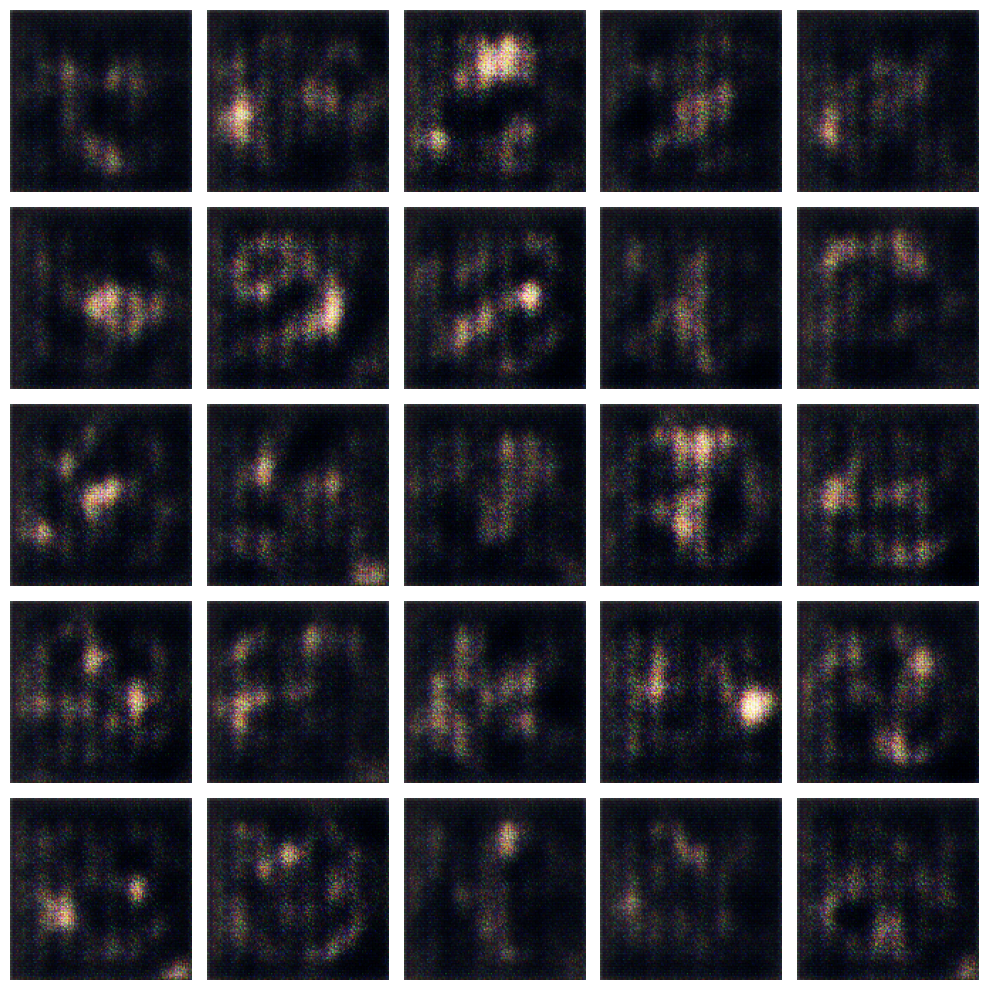


Training complete! Synthetic shrimp images have been generated.


In [19]:
# Main execution
def main():
    try:
        # Load the shrimp image dataset
        print("Loading shrimp image dataset...")
        dataset = load_and_preprocess_data(DATASET_PATH)

        # Display model summaries
        print("\nGenerator Model Summary:")
        generator.summary()

        print("\nDiscriminator Model Summary:")
        discriminator.summary()

        # Train the GAN
        print("\nStarting GAN training...")
        train(dataset, EPOCHS)

        # Generate a batch of synthetic images
        print("\nGenerating synthetic shrimp images...")
        generate_synthetic_batch(generator, n_samples=100)

        print("\nTraining complete! Synthetic shrimp images have been generated.")

    except Exception as e:
        print(f"An error occurred: {str(e)}")

# Run the main function to start training
main()

In [20]:
# Create a zip file of all the synthetic images
!zip -r synthetic_shrimps.zip /content/synthetic_shrimps

# This will create a downloadable zip file
from google.colab import files
files.download('synthetic_shrimps.zip')

  adding: content/synthetic_shrimps/ (stored 0%)
  adding: content/synthetic_shrimps/synthetic_shrimp_49.png (deflated 0%)
  adding: content/synthetic_shrimps/synthetic_shrimp_55.png (deflated 0%)
  adding: content/synthetic_shrimps/synthetic_shrimp_3.png (deflated 0%)
  adding: content/synthetic_shrimps/synthetic_shrimp_28.png (deflated 0%)
  adding: content/synthetic_shrimps/synthetic_shrimp_32.png (deflated 0%)
  adding: content/synthetic_shrimps/synthetic_shrimp_84.png (deflated 0%)
  adding: content/synthetic_shrimps/synthetic_shrimp_68.png (deflated 0%)
  adding: content/synthetic_shrimps/synthetic_shrimp_73.png (deflated 0%)
  adding: content/synthetic_shrimps/synthetic_shrimp_77.png (deflated 0%)
  adding: content/synthetic_shrimps/synthetic_shrimp_76.png (deflated 0%)
  adding: content/synthetic_shrimps/synthetic_shrimp_88.png (deflated 0%)
  adding: content/synthetic_shrimps/synthetic_shrimp_62.png (deflated 0%)
  adding: content/synthetic_shrimps/synthetic_shrimp_98.png (def

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>